set api_key from Command Prompt before opening notebook

## Load Raw Data

In [6]:
!pip install ratelimit

Processing c:\users\oluntung\appdata\local\pip\cache\wheels\8e\34\5e\1dd3d652594bdf5df01109a683a455121d0b726978051bf720\ratelimit-2.2.1-py3-none-any.whl


This notebook only retrieves ActiveEnergy_consumption_kWh energy logs for Meter 17600, which is the aggregate of the physical Meters 10000 to 17400 inclusive. 

Meters:17600
StartDate: 01/05/2020
EndDate: 30/09/2020
Meter 17600 is the aggregate of the all meters(i.e only ActiveEnergy_consumption_kWh and Power_kW available) 

In [2]:
StartDate = '01/05/2020'
EndDate = '30/09/2020'

In [4]:
%run -i "getData.py"

Enter Starting meter: 17600
Enter Ending meter: 17600


Select Output of 'rawData.py' to produce df DataFrame only and not raw_df Dataframe before running the next command line 

In [5]:
%%time
## Get Raw Data
### Merge into single dataframe
%run -i "rawData.py"

Enter Starting meter: 17600
Enter Ending meter: 17600


C:\Users\oluntung\Anaconda3\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS request is being made to host 'catalyst.visualx.online'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


ActiveEnergy_consumption_kWh data loaded
Wall time: 8.8 s


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14685 entries, 0 to 14684
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   time                          14685 non-null  object 
 1   meter                         14685 non-null  int64  
 2   ActiveEnergy_consumption_kWh  14685 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 344.3+ KB


### Clean df DataFrame

In [6]:
#Ordering Categories 
cat = ["January","February","March","April","May","June","July","August","September","October","November","December"]
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert Time into timestamp
df['time'] = pd.to_datetime(df['time'])

time_interval = df['time'].max()-df['time'].min()
print("start:",df['time'].min(), "\nend:",df['time'].max(), "\nduration:", time_interval)

start: 2020-05-01 00:00:00 
end: 2020-09-30 23:00:00 
duration: 152 days 23:00:00


Create individual DataFrames for different sampling rates 

In [7]:
### Energy Consumption dataframe
EnergyConsumption_df = df
EnergyConsumption_df["time_hourly"] = EnergyConsumption_df["time"].dt.to_period("H")
EnergyConsumption_df["time_day"] = EnergyConsumption_df["time"].dt.to_period("D")
EnergyConsumption_df['time_month'] = EnergyConsumption_df['time'].dt.to_period('M')

### Monthly Timestamps
E_monthly = EnergyConsumption_df.groupby(['meter','time_month'])['ActiveEnergy_consumption_kWh'].sum().reset_index()
E_monthly['month'] = E_monthly['time_month'].dt.strftime('%B')
E_monthly['month'] = pd.Categorical(E_monthly['month'],categories = cat, ordered = True)

### Daily Timestamps
E_daily = EnergyConsumption_df.groupby(['meter','time_day'])['ActiveEnergy_consumption_kWh'].sum().reset_index()
E_daily['month'] = E_daily['time_day'].dt.strftime('%B')
E_daily['month'] = pd.Categorical(E_daily['month'],categories = cat, ordered = True)
E_daily['day'] = E_daily['time_day'].dt.strftime('%A')
E_daily['day'] =  pd.Categorical(E_daily['day'],categories = cats, ordered = True)
E_daily['week'] = E_daily['time_day'].dt.strftime('%W')  # Monday as start of week
E_daily['week'] = E_daily['week'].astype('int64')

### Hourly Timestamps
EnergyConsumption_df = EnergyConsumption_df.groupby(["meter",'time_hourly'])['ActiveEnergy_consumption_kWh'].sum().reset_index()

EnergyConsumption_df["0.5kWh<x<2.0Wh"] =(EnergyConsumption_df['ActiveEnergy_consumption_kWh'] > 0.5) & (EnergyConsumption_df['ActiveEnergy_consumption_kWh'] <= 2.0)
EnergyConsumption_df[">2.0kWh"] =(EnergyConsumption_df['ActiveEnergy_consumption_kWh'] > 2.0)
EnergyConsumption_df["<=0.5kWh"] =(EnergyConsumption_df['ActiveEnergy_consumption_kWh'] <= 0.5)
EnergyConsumption_df['month'] = EnergyConsumption_df['time_hourly'].dt.strftime('%B')
EnergyConsumption_df['month'] = pd.Categorical(EnergyConsumption_df['month'],categories = cat, ordered = True)
EnergyConsumption_df['week'] = EnergyConsumption_df['time_hourly'].dt.strftime('%W')  # Monday as start of week
EnergyConsumption_df['week'] = EnergyConsumption_df['week'].astype('int64')
EnergyConsumption_df['day'] = EnergyConsumption_df['time_hourly'].dt.strftime('%A')
EnergyConsumption_df['day'] =  pd.Categorical(EnergyConsumption_df['day'],categories = cats, ordered = True)
EnergyConsumption_df['hour'] = EnergyConsumption_df['time_hourly'].dt.hour

EnergyConsumption_df = EnergyConsumption_df[['meter','time_hourly','month','week','day','hour','ActiveEnergy_consumption_kWh',"<=0.5kWh","0.5kWh<x<2.0Wh",">2.0kWh"]]
E_monthly = E_monthly[['meter','time_month','month','ActiveEnergy_consumption_kWh']]
E_daily = E_daily[['meter','time_day','month','week','day','ActiveEnergy_consumption_kWh']]


In [8]:
###Seasons 
EnergyConsumption_df.loc[((EnergyConsumption_df['month'] == 'December') | (EnergyConsumption_df['month'] == 'January')| (EnergyConsumption_df['month'] == 'February')),'season'] = 'Summer'
EnergyConsumption_df.loc[((EnergyConsumption_df['month'] == 'March') | (EnergyConsumption_df['month'] == 'April') | (EnergyConsumption_df['month'] == 'May')),'season'] = 'Autumn'
EnergyConsumption_df.loc[((EnergyConsumption_df['month'] == 'June') | (EnergyConsumption_df['month'] == 'July')| (EnergyConsumption_df['month'] == 'August')),'season'] = 'Winter'
EnergyConsumption_df.loc[((EnergyConsumption_df['month'] == 'September') | (EnergyConsumption_df['month'] == 'October')| (EnergyConsumption_df['month'] == 'November')),'season'] = 'Spring'

In [9]:
### Sampling Frequency: Hourly 
EnergyConsumption_df.head(5)

,meter,time_hourly,month,week,day,hour,ActiveEnergy_consumption_kWh,<=0.5kWh,0.5kWh<x<2.0Wh,>2.0kWh,season
0,17600,2020-05-01 00:00,May,17,Friday,0,5.360242,False,False,True,Autumn
1,17600,2020-05-01 01:00,May,17,Friday,1,4.950242,False,False,True,Autumn
2,17600,2020-05-01 02:00,May,17,Friday,2,5.420242,False,False,True,Autumn
3,17600,2020-05-01 03:00,May,17,Friday,3,5.050242,False,False,True,Autumn
4,17600,2020-05-01 04:00,May,17,Friday,4,5.450242,False,False,True,Autumn


In [10]:
### Sampling Frequency: Daily
E_daily.head(5)

,meter,time_day,month,week,day,ActiveEnergy_consumption_kWh
0,17600,2020-05-01,May,17,Friday,209.683909
1,17600,2020-05-02,May,17,Saturday,175.713002
2,17600,2020-05-03,May,17,Sunday,146.373002
3,17600,2020-05-04,May,18,Monday,229.923000
4,17600,2020-05-05,May,18,Tuesday,176.953002


In [11]:
### Sampling Frequency: Monthly
E_monthly.head(5)

,meter,time_month,month,ActiveEnergy_consumption_kWh
0,17600,2020-05,May,2994.850696
1,17600,2020-06,June,6690.566903
2,17600,2020-07,July,9399.591823
3,17600,2020-08,August,11045.159779
4,17600,2020-09,September,11087.629778


# Analysis of Data
Produce Pivot Tables to analyse different sampling frequencies 

In [13]:
### Create Pivot Tables
months = list(EnergyConsumption_df["month"].unique())

### Pivot Tables for ActiveEnergy_consumption_kWh
# Below pivot tables used for plots 

pivot = df.pivot_table(values='ActiveEnergy_consumption_kWh',index='time', columns='meter')

### Total consumption for the hour
hourly_consumption = pivot.resample("H").sum() 
hourly_stat = hourly_consumption.agg([np.sum,np.mean,np.std,np.min,np.max])

### Total consumption on each day 
daily = hourly_consumption.resample("D")
daily_total  = daily.sum() 
daily_stat = daily.agg([np.sum,np.mean,np.std,np.min,np.max])

### Total consumption for the month 
monthly = daily_total.resample("M")
monthly_total = monthly.sum(min_count=28)
monthly_total = monthly_total.set_index([pd.Index(range(len(months)))])
monthly_total.insert(0,"month",months)
monthly_stat = monthly.agg([np.sum,np.mean,np.std,np.min,np.max])

In [14]:
monthly_stat

17600                                                
                     sum        mean         std        amin        amax
time                                                                    
2020-05-31   2994.850696   96.608087   50.862482   16.680573  229.923000
2020-06-30   6690.566903  223.018897   62.506538  111.920171  403.200863
2020-07-31   9399.591823  303.212639   96.396818  136.305881  568.430860
2020-08-31  11045.159779  356.295477  110.203666  154.499997  663.539086
2020-09-30  11087.629778  369.587659   69.061913  202.339996  481.239990

In [15]:
daily_stat

17600                                          
                   sum       mean       std      amin       amax
time                                                            
2020-05-01  209.683909   8.736830  3.844961  4.950242  16.900125
2020-05-02  175.713002   7.321375  2.338796  5.130125  11.350125
2020-05-03  146.373002   6.098875  0.921196  5.010125   7.650125
2020-05-04  229.923000   9.580125  4.566089  5.080125  19.640125
2020-05-05  176.953002   7.373042  4.240840  4.010125  15.380125
...                ...        ...       ...       ...        ...
2020-09-26  436.849991  18.202083  6.717418  8.780000  30.399999
2020-09-27  434.059991  18.085833  5.761294  9.890000  32.799999
2020-09-28  467.629991  19.484583  7.387635  9.620000  34.809999
2020-09-29  481.239990  20.051666  7.057281  9.170000  33.379999
2020-09-30  460.819991  19.200833  6.976459  3.450000  28.819999

[153 rows x 5 columns]

In [16]:
hourly_stat

,17600
sum,41217.798980
mean,11.224891
std,6.715511
amin,0.620024
amax,79.620794


### Summary Statistics 
Based on the calculated meter for the aggregate of all physical meters. 

In [46]:
###Total consumption of the site for the specified time interval 
print("Total consumption of the site for specified time interval of:",time_interval,"\nis",EnergyConsumption_df['ActiveEnergy_consumption_kWh'].sum().round(5),"kWh")

Total consumption of the site for specified time interval of: 152 days 23:00:00 
is 41217.79898 kWh


In [47]:
### Average Monthly consumption for the site 
print("The average consumption for the site was:\n",E_monthly['ActiveEnergy_consumption_kWh'].mean().round(5),"kWh per month")

The average consumption for the site was:
 8243.5598 kWh per month


In [19]:
### Average Daily consumption per meter for time interval 
print("The average consumption for the site was:\n",E_daily['ActiveEnergy_consumption_kWh'].mean().round(5),"kWh per day")

The average consumption for the site was:
 269.3973789530709 kWh per day


In [20]:
### Average Hourly consumption per meter for time interval
## Site consumed an average of 11.225 kWh per hour 
print("The average consumption for the site per hour was:\n",EnergyConsumption_df['ActiveEnergy_consumption_kWh'].mean().round(5),"kWh ")

The average consumption for the site per hour was:
 11.22489078971129 kWh 


## Visualisation of Data

In [21]:
%matplotlib notebook

<IPython.core.display.Javascript object>


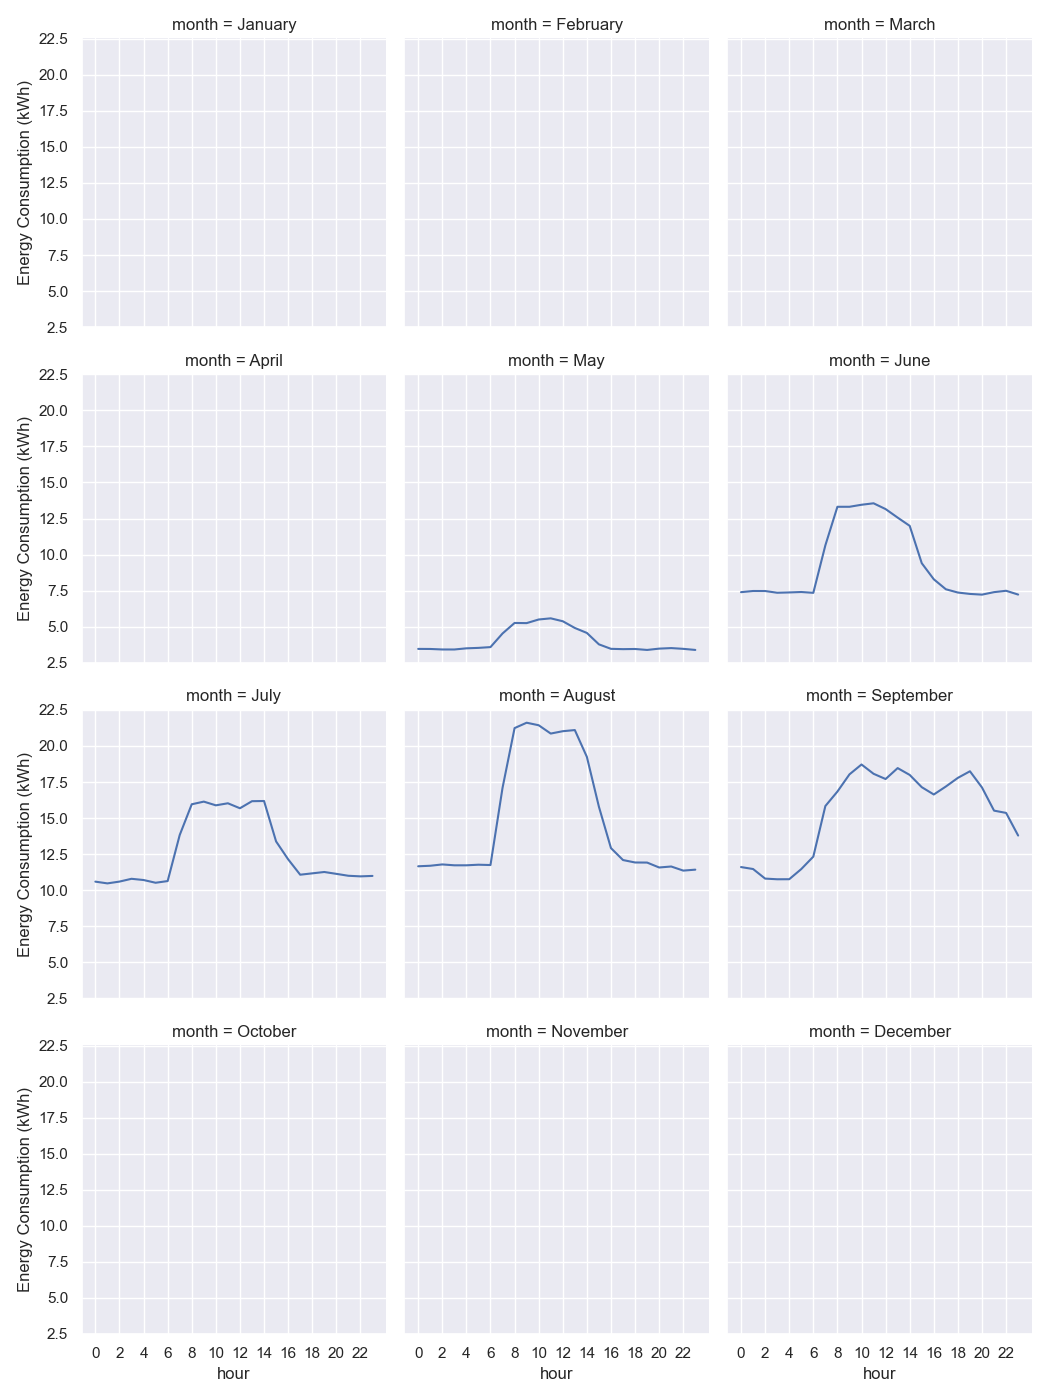

In [22]:
### Consumption throughout a typical day of the month
sns.set(style='darkgrid')
G = pivot_hour['mean'].reset_index()
g = sns.FacetGrid(G, col = 'month', height = 3.5, aspect = 1, col_wrap = 3)
g.map(sns.lineplot,'hour',17600)
g.set(xticks=range(0,24,2))
g.set_axis_labels('hour','Energy Consumption (kWh)')

<IPython.core.display.Javascript object>


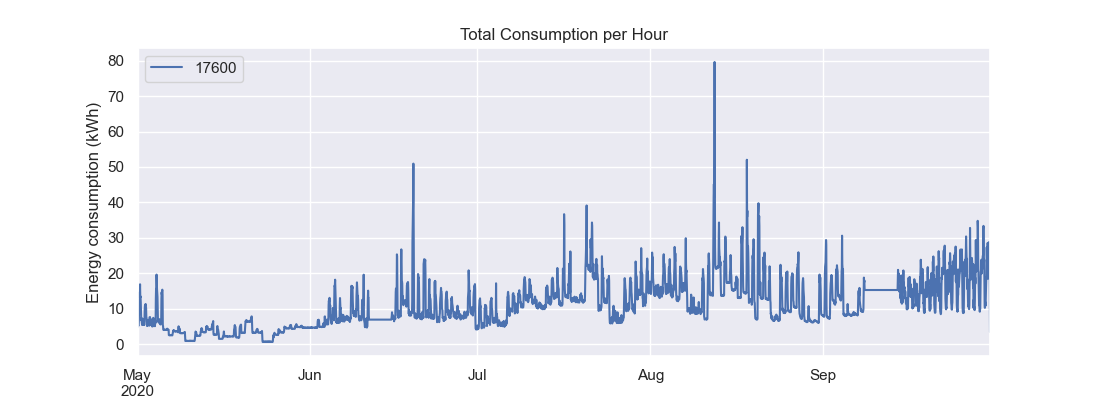

In [23]:
### Figure 1 - Hourly Consumption for entire site  
sns.set(rc={'figure.figsize': (11, 4)})
sns.set(style='darkgrid')
hourly_consumption.plot(xlabel="Date",ylabel="Energy consumption (kWh)")
plt.title("Total Consumption per Hour")
plt.legend(loc = "upper left",ncol=1)
# note: meter 10000 is "check meter"; meter 10100 is "house meter", meter 10200 - "commercial tennant 1", meter 10300 -"commercial tennant 2"

<IPython.core.display.Javascript object>


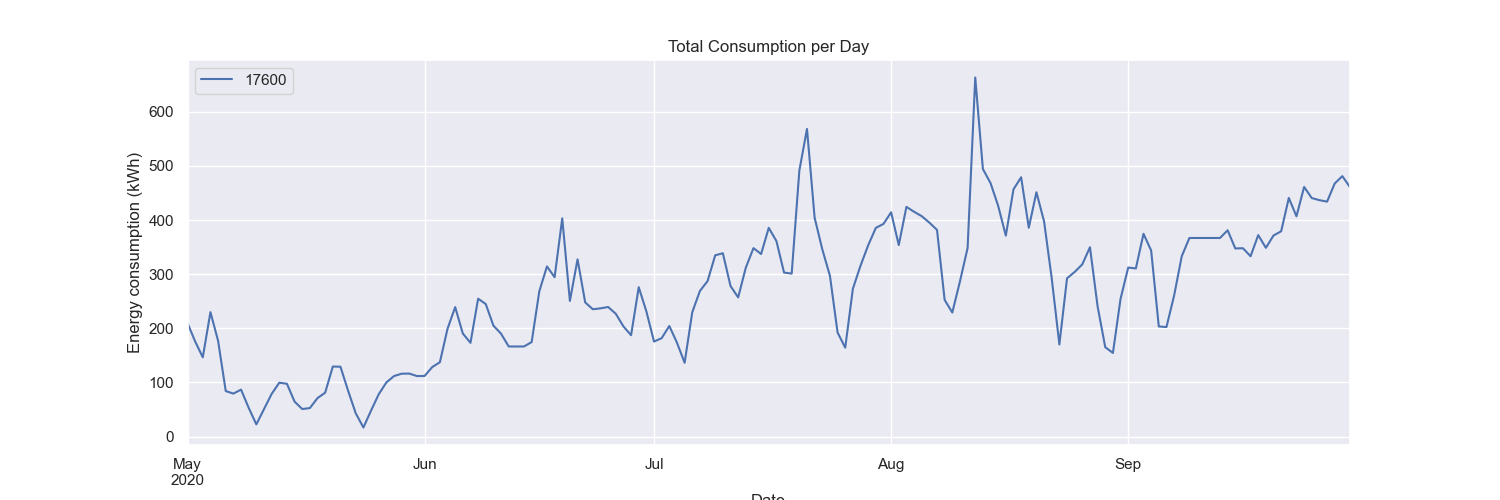

In [24]:
###  Figure 2 - Daily Consumption for entire site 
sns.set(rc={'figure.figsize': (15, 5)})
daily_total.plot(xlabel="Date",ylabel="Energy consumption (kWh)",kind ='line')
plt.title("Total Consumption per Day")
plt.legend(loc = "upper left",ncol=2)

<IPython.core.display.Javascript object>


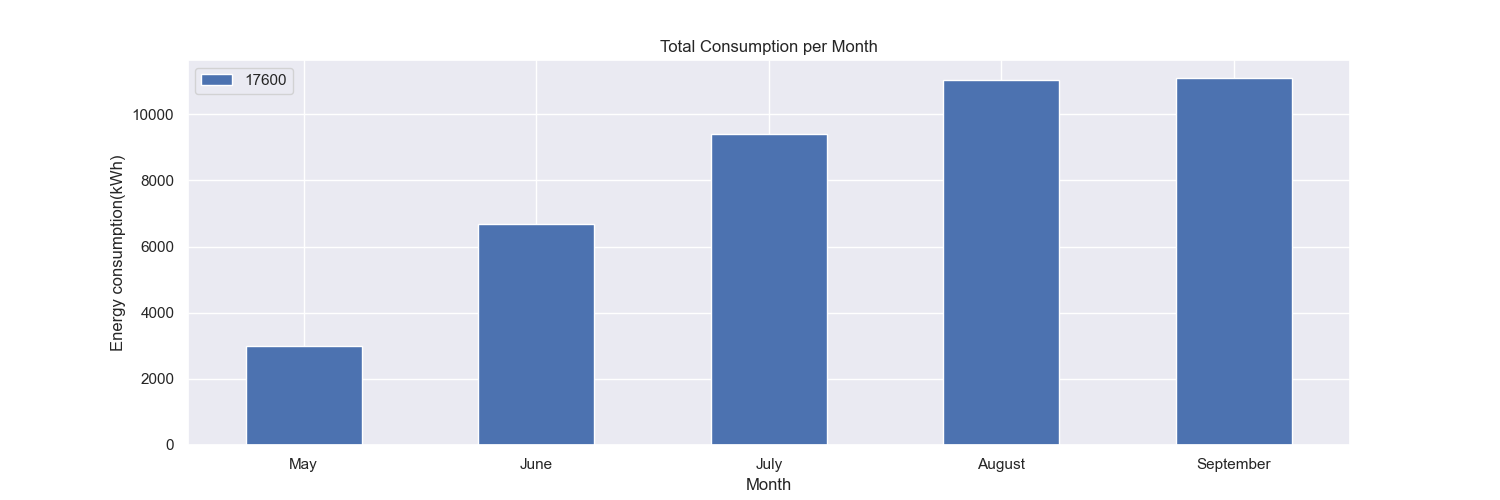

In [25]:
### Figure 3 - Monthly Consumption for entire site 
monthly_total.plot(kind='bar',x='month')
# monthly_total.plot(kind='line')
plt.title("Total Consumption per Month")
plt.xlabel("Month")
plt.ylabel("Energy consumption(kWh)")
plt.xticks(rotation=0)
plt.legend(loc = 'upper left',ncol=2)

<IPython.core.display.Javascript object>


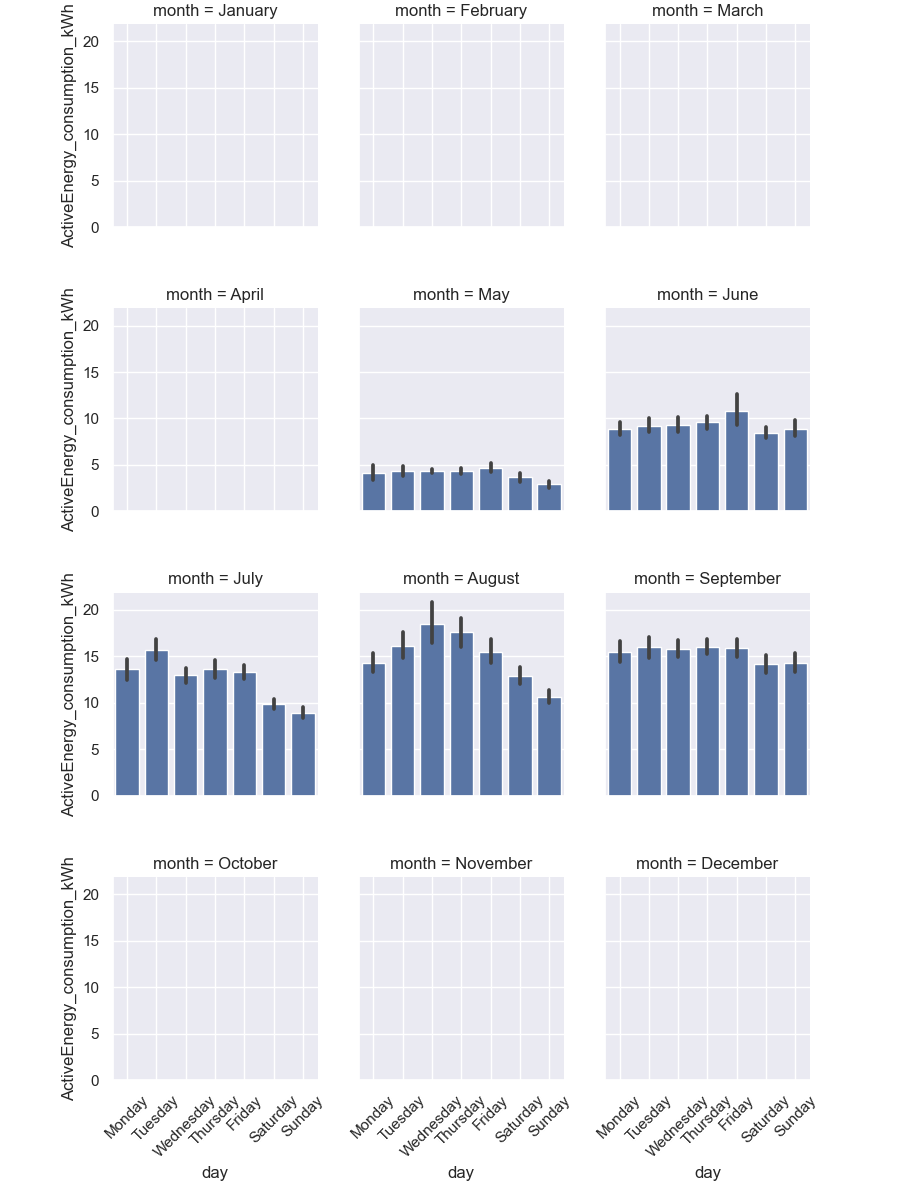

In [26]:
### Typical consumption per week for the month 
e  = sns.FacetGrid(EnergyConsumption_df, col = 'month',col_wrap =3, height = 3.0,)
e.map(sns.barplot,'day','ActiveEnergy_consumption_kWh', order = cats)
e.set_xticklabels(rotation=45)
plt.subplots_adjust(left = 0.125, right = 0.9, bottom = 0.1, top = 0.98, wspace = 0.2, hspace= 0.4)

Filter Dataframe to view individual month 

<IPython.core.display.Javascript object>


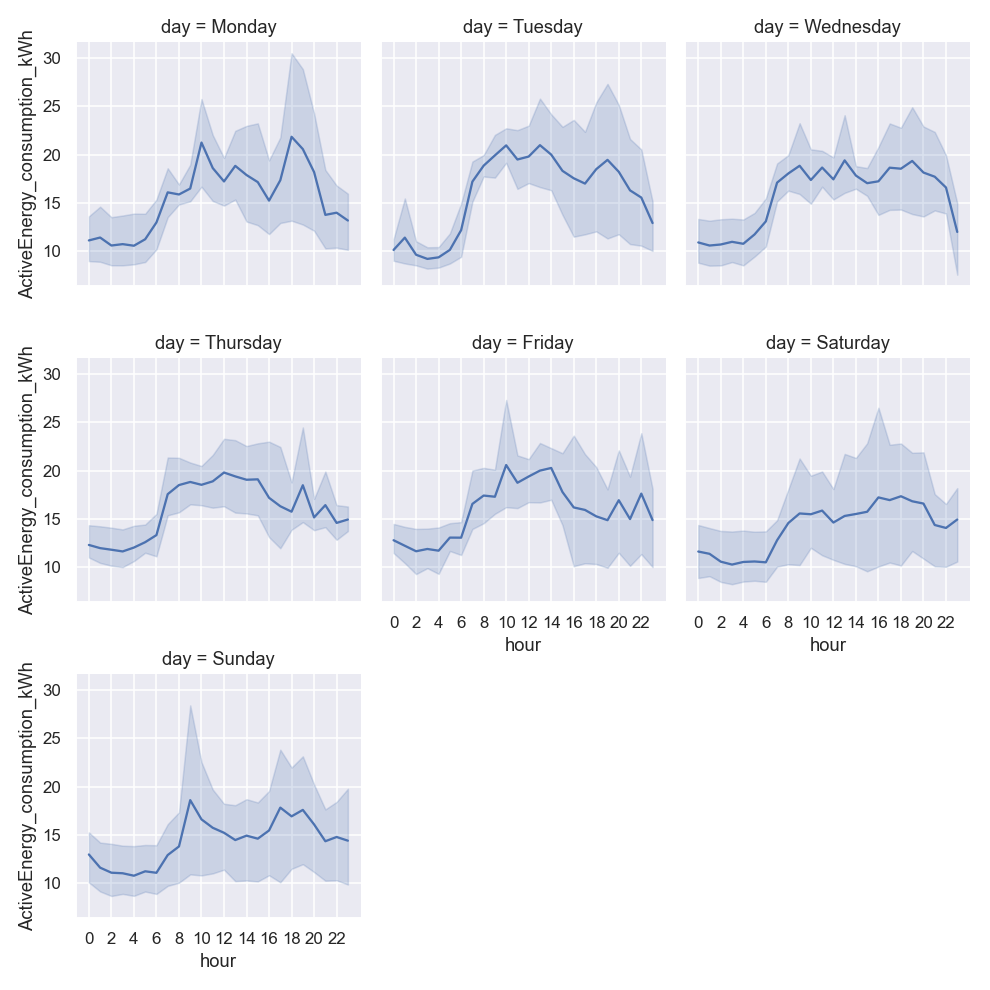

Wall time: 3.55 s


In [44]:
### Weekly Snapshot for the Selected month 
%%time
###  Select which month to analyse (i.e. August)
M = EnergyConsumption_df.groupby(['month']).get_group('September')
Mo = sns.FacetGrid(M,col='day', col_wrap = 3)
Mo.map(sns.lineplot,'hour','ActiveEnergy_consumption_kWh')
Mo.set(xticks=range(0,24,2))

<IPython.core.display.Javascript object>


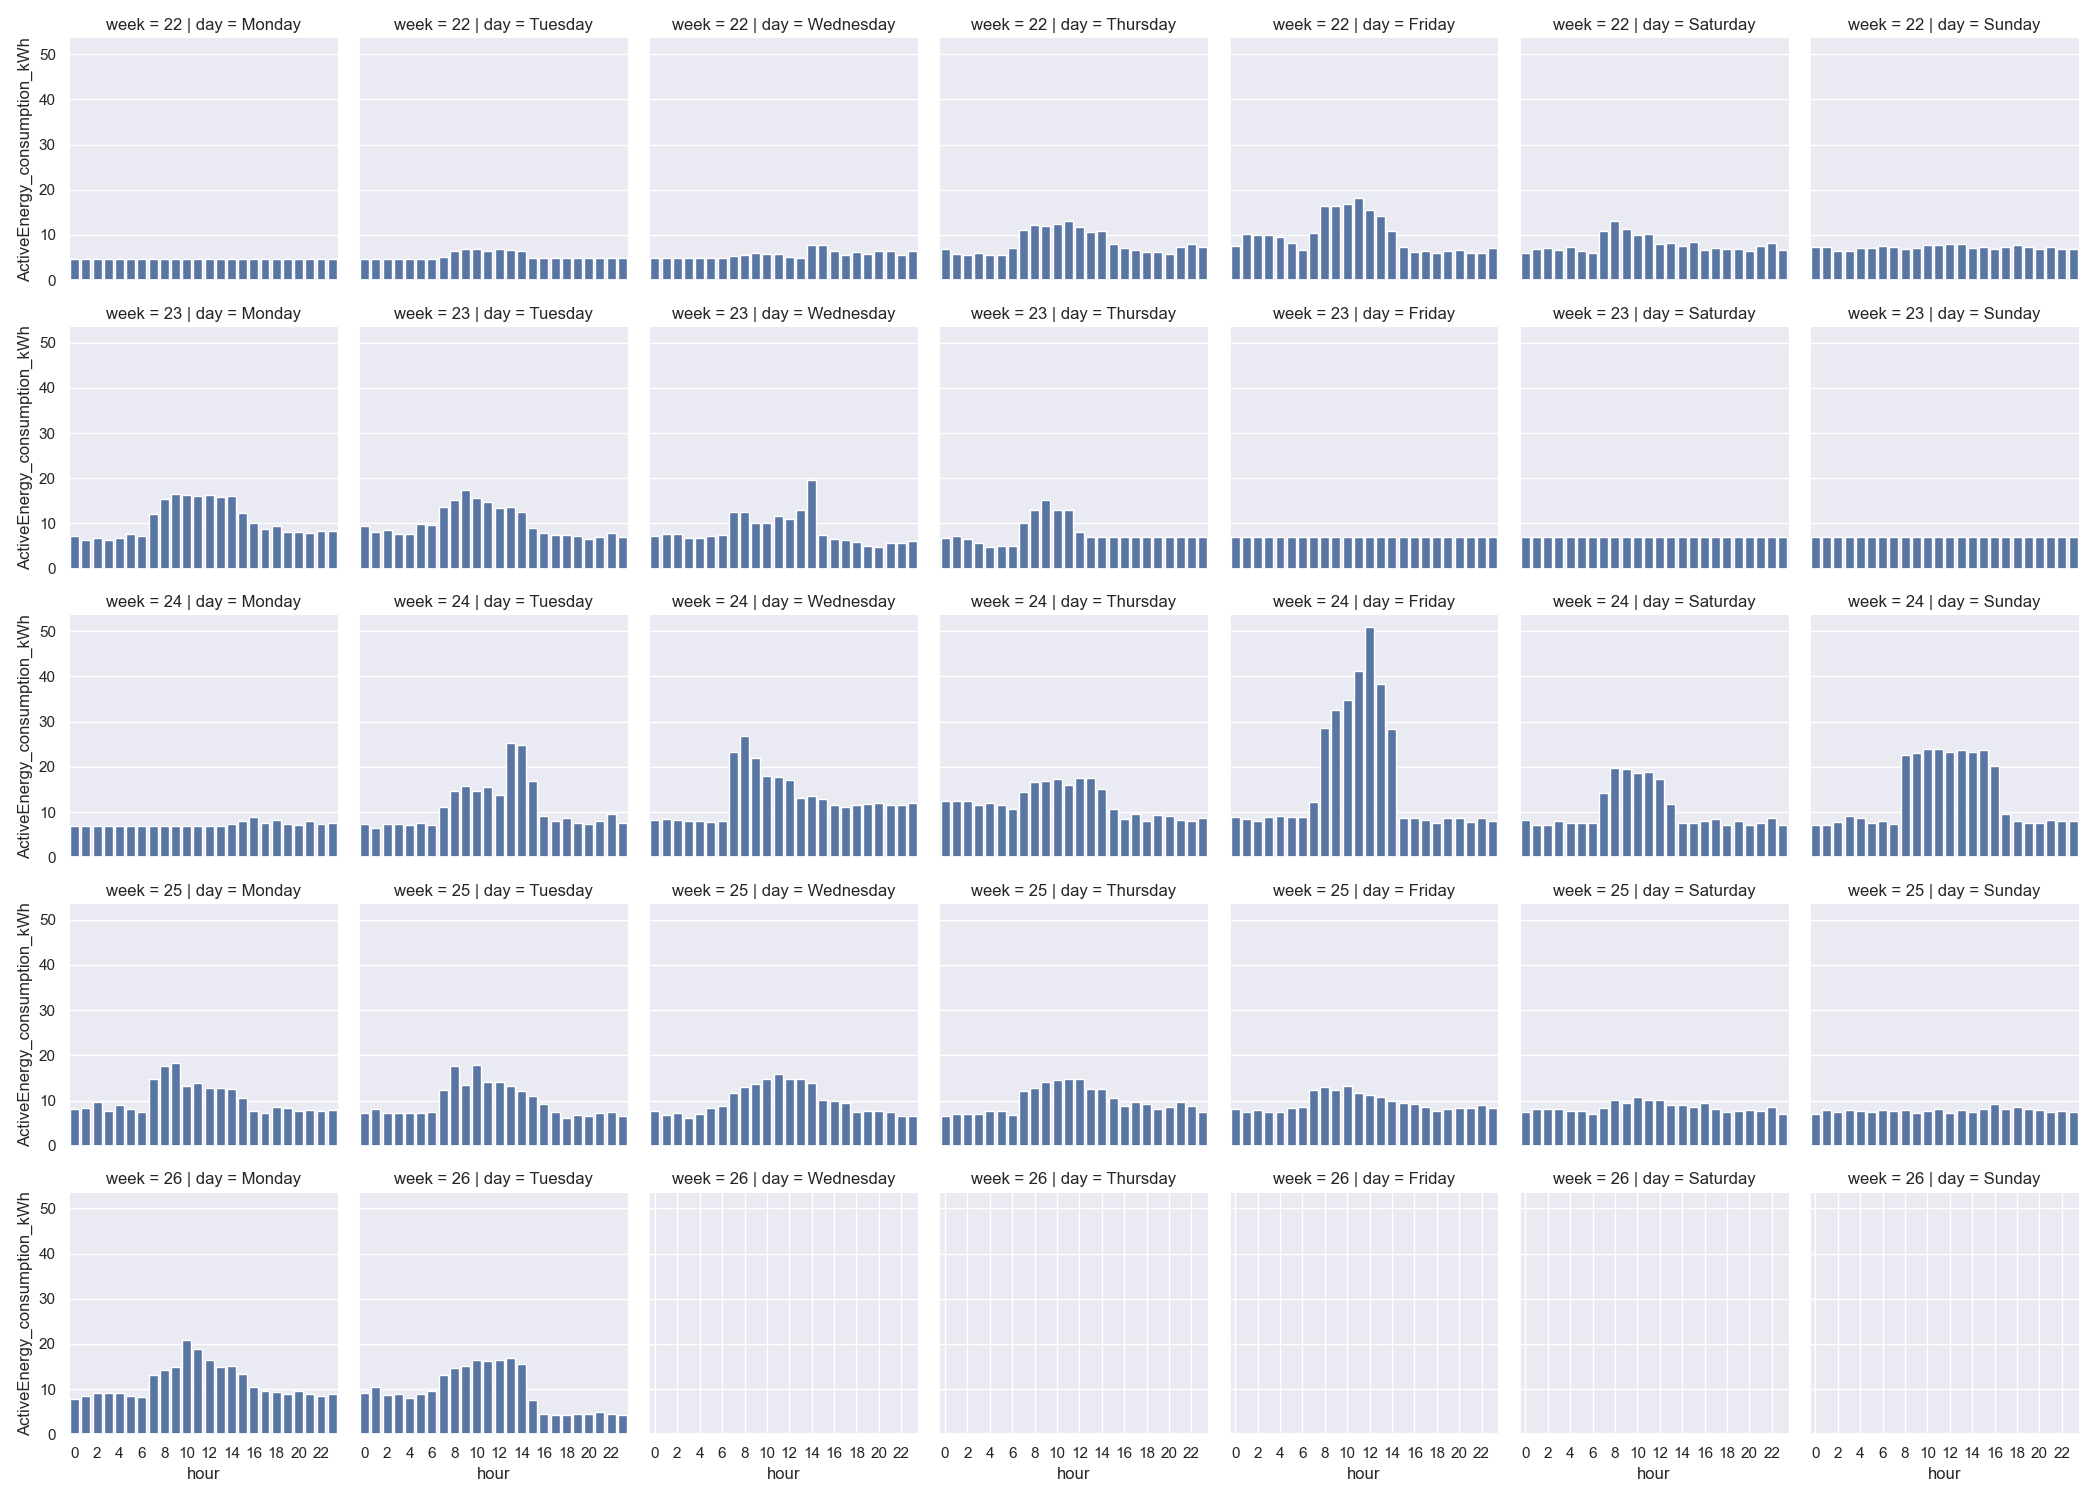

Wall time: 4.72 s


In [29]:
### Consumption for each day of the selected month 
%%time 
### Matches with Optergy graphs
###  Select which month and meter to analyse (i.e. "June")
J = EnergyConsumption_df.groupby(['month']).get_group("June")
June = sns.FacetGrid(J,col='day', row = 'week')
# June.map(sns.lineplot,'hour','ActiveEnergy_consumption_kWh')
June.map(sns.barplot,'hour','ActiveEnergy_consumption_kWh',order = range(24))
June.set(xticks=range(0,24,2))

Determine the instances by the hour, when the maximum consumption occurs each day 

In [31]:
### Instance of Maximum Hourly Consumption for entire time_interval
EnergyConsumption_df[EnergyConsumption_df['ActiveEnergy_consumption_kWh']==EnergyConsumption_df['ActiveEnergy_consumption_kWh'].max()]

,meter,time_hourly,month,week,day,hour,ActiveEnergy_consumption_kWh,<=0.5kWh,0.5kWh<x<2.0Wh,>2.0kWh,season
2485,17600,2020-08-12 13:00,August,32,Wednesday,13,79.620794,False,False,True,Winter


In [33]:
### Instances of Maximum Hourly Consumption per day 
Max_df = EnergyConsumption_df[EnergyConsumption_df['ActiveEnergy_consumption_kWh']==EnergyConsumption_df.groupby(['week','day'])['ActiveEnergy_consumption_kWh'].transform('max')]
Max_df = Max_df[['meter','time_hourly','month','week','day','hour','ActiveEnergy_consumption_kWh']]
Max_df

,meter,time_hourly,month,week,day,hour,ActiveEnergy_consumption_kWh
11,17600,2020-05-01 11:00,May,17,Friday,11,16.900125
35,17600,2020-05-02 11:00,May,17,Saturday,11,11.350125
54,17600,2020-05-03 06:00,May,17,Sunday,6,7.650125
82,17600,2020-05-04 10:00,May,18,Monday,10,19.640125
107,17600,2020-05-05 11:00,May,18,Tuesday,11,15.380125
...,...,...,...,...,...,...,...
3568,17600,2020-09-26 16:00,September,38,Saturday,16,30.399999
3585,17600,2020-09-27 09:00,September,38,Sunday,9,32.799999
3618,17600,2020-09-28 18:00,September,39,Monday,18,34.809999
3643,17600,2020-09-29 19:00,September,39,Tuesday,19,33.379999


<IPython.core.display.Javascript object>


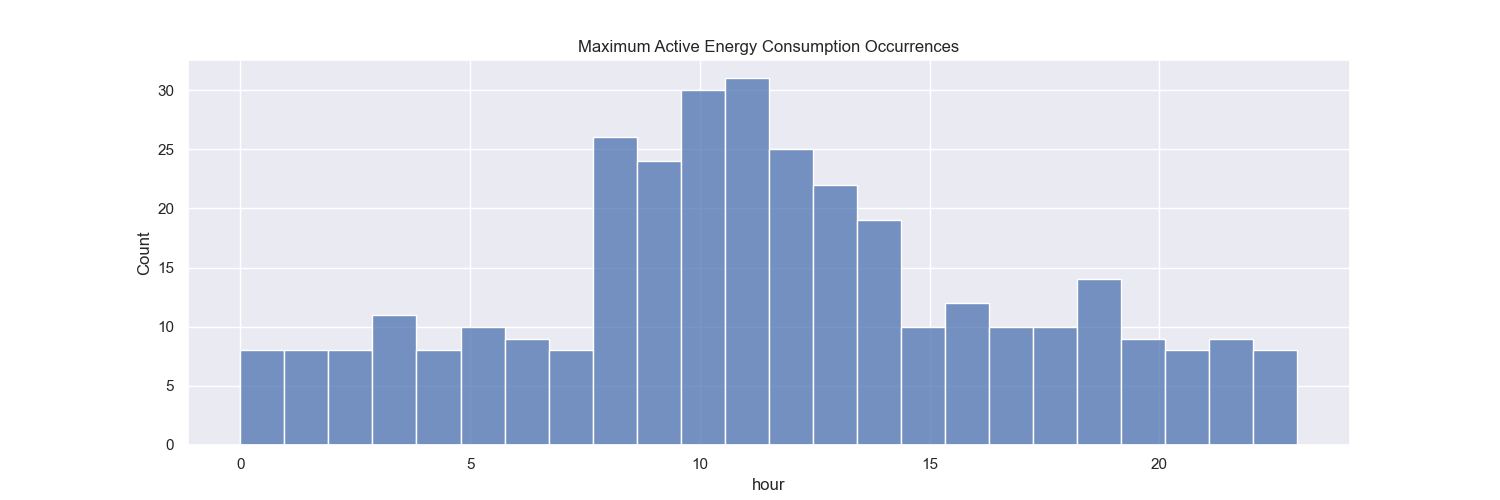

Text(0.5, 1.0, 'Maximum Active Energy Consumption Occurrences')

In [34]:
### Figure - Histogram of instances of maximum hourly consumption 
sns.histplot(Max_df['hour'], bins =24)
plt.title("Maximum Active Energy Consumption Occurrences")
### Highest occurrence of peak consumption is between 8:00 to 14:00 

In [35]:
### Instances of Minimum Hourly consumption per day 
Min_df = EnergyConsumption_df[EnergyConsumption_df['ActiveEnergy_consumption_kWh']==EnergyConsumption_df.groupby(['week','day'])['ActiveEnergy_consumption_kWh'].transform('min')]
Min_df = Min_df[['meter','time_hourly','month','week','day','hour','ActiveEnergy_consumption_kWh']]
Min_df

,meter,time_hourly,month,week,day,hour,ActiveEnergy_consumption_kWh
1,17600,2020-05-01 01:00,May,17,Friday,1,4.950242
41,17600,2020-05-02 17:00,May,17,Saturday,17,5.130125
64,17600,2020-05-03 16:00,May,17,Sunday,16,5.010125
75,17600,2020-05-04 03:00,May,18,Monday,3,5.080125
119,17600,2020-05-05 23:00,May,18,Tuesday,23,4.010125
...,...,...,...,...,...,...,...
3557,17600,2020-09-26 05:00,September,38,Saturday,5,8.780000
3581,17600,2020-09-27 05:00,September,38,Sunday,5,9.890000
3605,17600,2020-09-28 05:00,September,39,Monday,5,9.620000
3627,17600,2020-09-29 03:00,September,39,Tuesday,3,9.170000


<IPython.core.display.Javascript object>


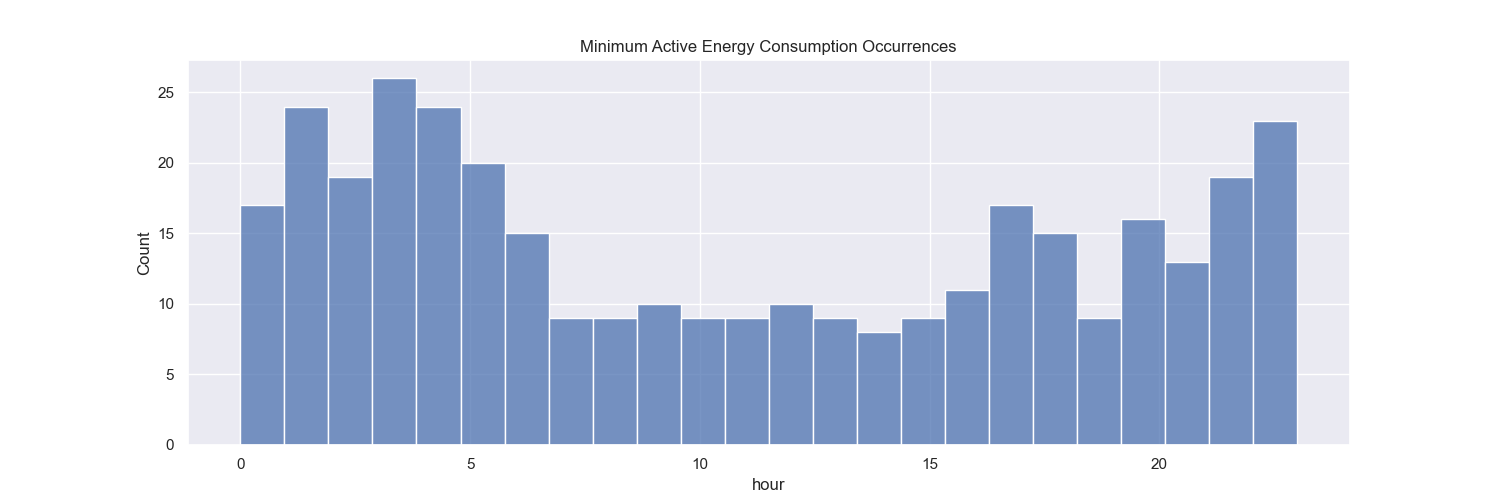

Text(0.5, 1.0, 'Minimum Active Energy Consumption Occurrences')

In [36]:
sns.histplot(Min_df['hour'], bins =24)
plt.title("Minimum Active Energy Consumption Occurrences")

In [37]:
### Instance of maximum daily consumption for the week 
Max_w_df = E_daily[E_daily['ActiveEnergy_consumption_kWh']==E_daily.groupby(['week'])['ActiveEnergy_consumption_kWh'].transform('max')]
Max_w_df = Max_w_df[['meter','time_day','month','week','day','ActiveEnergy_consumption_kWh']]
Max_w_df

,meter,time_day,month,week,day,ActiveEnergy_consumption_kWh
0,17600,2020-05-01,May,17,Friday,209.683909
3,17600,2020-05-04,May,18,Monday,229.923000
12,17600,2020-05-13,May,19,Wednesday,99.482040
19,17600,2020-05-20,May,20,Wednesday,129.380571
29,17600,2020-05-30,May,21,Saturday,116.350170
35,17600,2020-06-05,June,22,Friday,239.200168
38,17600,2020-06-08,June,23,Monday,254.720168
49,17600,2020-06-19,June,24,Friday,403.200863
52,17600,2020-06-22,June,25,Monday,247.910866
59,17600,2020-06-29,June,26,Monday,275.913320


<IPython.core.display.Javascript object>


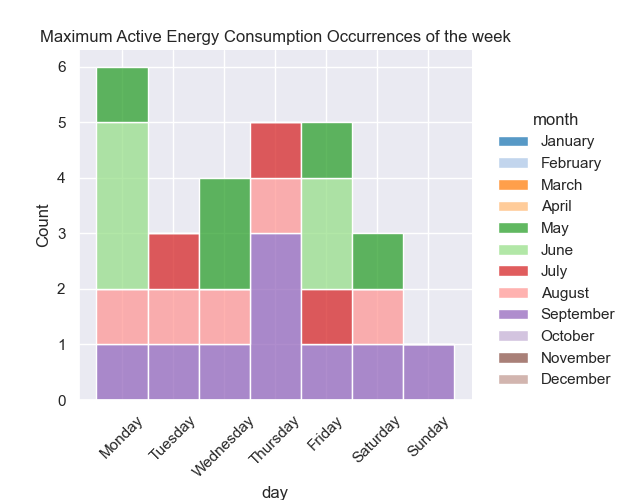

In [38]:
### Note Week 36 of September had the same max consumption for 5 days 
# sns.histplot(Max_w_df['day'], bins =7)
sns.set(rc={'figure.figsize': (11, 4)})
sns.set(style='darkgrid')
sns.displot(data=Max_w_df, x ='day',hue ='month',multiple ='stack',palette='tab20')
plt.title("Maximum Active Energy Consumption Occurrences of the week")
plt.xticks(rotation=45)
plt.subplots_adjust(left = 0.125, right = 0.75, bottom = 0.2, top = 0.9, wspace = 0.2, hspace= 0.4)

<IPython.core.display.Javascript object>


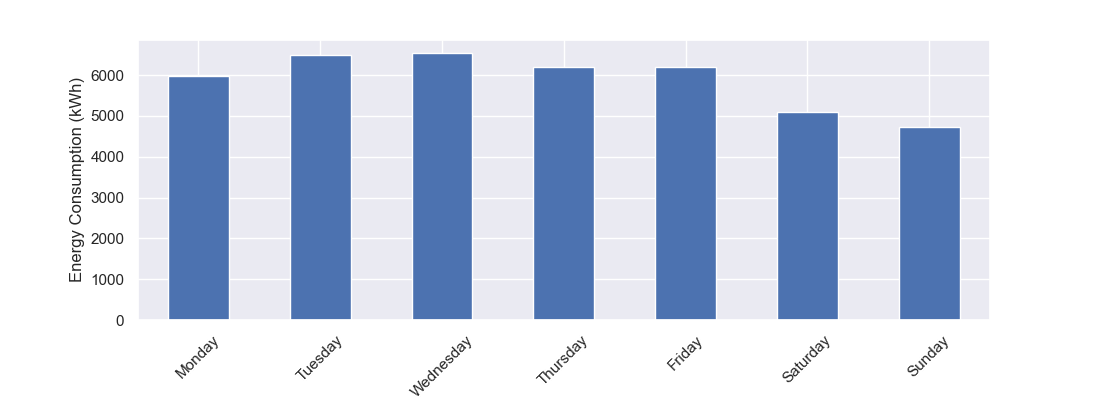

In [42]:
### Total Day of the week consumption for entire time period
E_daily.groupby('day')['ActiveEnergy_consumption_kWh'].sum().plot(kind='bar',x='day',ylabel='Energy Consumption (kWh)')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom = 0.2, top = 0.9)

<IPython.core.display.Javascript object>


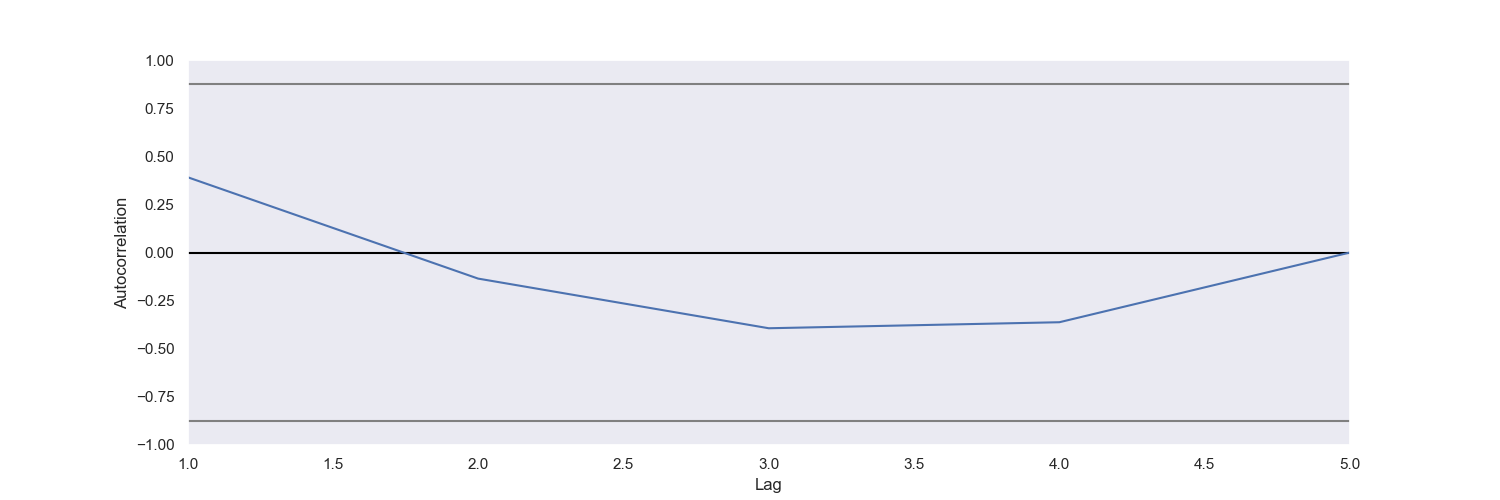

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

In [30]:
### Autocorrelation plot for the calculated site consumption 
df_auto = df
df_auto = df_auto.set_index('time')
pd.plotting.autocorrelation_plot(df_auto["ActiveEnergy_consumption_kWh"].resample("1m").median())